In [1]:
import mlx.core as mx
import mlx.nn as nn
import numpy as np
from mlx.data import datasets
from datasets_utils import cifar100


In [2]:
def get_streamed_data(data, batch_size=0, shuffled=True):
    def transform_image(x):
        return x.astype("float32") / 255.0

    buffer = data.shuffle() if shuffled else data
    stream = buffer.to_stream()
    stream = stream.key_transform("image", transform_image)
    stream = stream.batch(batch_size) if batch_size > 0 else stream
    return stream.prefetch(4, 2)

In [3]:
train_data = datasets.load_cifar100(train=True)
test_data = datasets.load_cifar100(train=False)

len(train_data), len(test_data)

(50000, 10000)

In [4]:
# partition train_data into 5 partitions and return the first partition (index 0)
partitioned = train_data.partition(5, 0)
print(f"Partition length: {len(partitioned)}")

streamed_partition = get_streamed_data(partitioned, batch_size=1, shuffled=True)
batch = next(streamed_partition)
print(f"Batch image shape: {batch['image'].shape}\nBatch label shape: {batch['label'].shape}")
print(f"Original data length: {len(train_data)}")

Partition length: 10000
Batch image shape: (1, 32, 32, 3)
Batch label shape: (1,)
Original data length: 50000


In [5]:
class Model(nn.Module):
    def __init__(self, input_channel, input_width, conv_filters, output_dims):
        super().__init__()
        conv2d_kernel_size = 3
        conv2d_stride = 1
        conv2d_padding = 0

        pool2d_kernel_size = 2
        pool2d_stride = 2
        pool2d_padding = 0

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_channel,
                out_channels=conv_filters,
                kernel_size=(conv2d_kernel_size, conv2d_kernel_size),
                stride=conv2d_stride,
                padding=conv2d_padding
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=conv_filters,
                out_channels=conv_filters,
                kernel_size=(conv2d_kernel_size, conv2d_kernel_size),
                stride=conv2d_stride,
                padding=conv2d_padding
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool2d_kernel_size, stride=pool2d_stride, padding=pool2d_padding),
        )

        self.batch_norm1 = nn.BatchNorm(conv_filters)

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=conv_filters,
                out_channels=conv_filters,
                kernel_size=(conv2d_kernel_size, conv2d_kernel_size),
                stride=conv2d_stride,
                padding=conv2d_padding
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=conv_filters,
                out_channels=conv_filters,
                kernel_size=(conv2d_kernel_size, conv2d_kernel_size),
                stride=conv2d_stride,
                padding=conv2d_padding
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool2d_kernel_size, stride=pool2d_stride, padding=pool2d_padding),
        )

        self.batch_norm2 = nn.BatchNorm(conv_filters)

        self.fully_connected = nn.Sequential(
            nn.Linear(input_dims=5*5*conv_filters, output_dims=output_dims),
        )

    def __call__(self, x):
        x = self.conv_layer1(x)
        x = self.batch_norm1(x)
        x = self.conv_layer2(x)
        x = self.batch_norm2(x)
        x = mx.flatten(x, start_axis=1, end_axis=-1)
        x = self.fully_connected(x)
        return x

In [6]:
NUM_CLASSES = len(cifar100.labels)
INPUT_WIDTH = 32
INPUT_CHANNEL = 3
CONV_FILTERS = 128

model = Model(
    input_channel=INPUT_CHANNEL,
    input_width=INPUT_WIDTH,
    conv_filters=CONV_FILTERS,
    output_dims=NUM_CLASSES
)

mx.eval(model)
model

Model(
  (conv_layer1): Sequential(
    (layers.0): Conv2d(3, 128, kernel_size=(3,), stride=(1, 1), padding=(0, 0), dilation=1, bias=True)
    (layers.1): ReLU()
    (layers.2): Conv2d(128, 128, kernel_size=(3,), stride=(1, 1), padding=(0, 0), dilation=1, bias=True)
    (layers.3): ReLU()
    (layers.4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  )
  (batch_norm1): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_layer2): Sequential(
    (layers.0): Conv2d(128, 128, kernel_size=(3,), stride=(1, 1), padding=(0, 0), dilation=1, bias=True)
    (layers.1): ReLU()
    (layers.2): Conv2d(128, 128, kernel_size=(3,), stride=(1, 1), padding=(0, 0), dilation=1, bias=True)
    (layers.3): ReLU()
    (layers.4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  )
  (batch_norm2): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fully_connected): Sequential(
    (layers.0): Linear(input_dims=3200

In [7]:
import mlx.optimizers as optim
from dataclasses import dataclass
from typing import List

@dataclass
class Experiment:
    model: nn.Module
    optimizer: optim.Optimizer
    train_losses: List[float]
    train_accuracy: List[float]
    validation_accuracy: List[float]
    epoch: int = 30
    f1_score: float = 0.0
    recall_score: float = 0.0
    precision_score: float = 0.0
    description: str = ""

In [8]:
import trainer

# Create five experiments with each model having slightly different or even same
# Hyperparameters: learning rate, convolutional filters, etc.
# For the sake of fun :)

exp1 = Experiment(
    model=Model(input_channel=INPUT_CHANNEL,
                input_width=INPUT_WIDTH,
                output_dims=NUM_CLASSES,
                conv_filters=32),
    epoch=30,
    optimizer=optim.Adam(learning_rate=0.0001),
    train_losses=[],
    train_accuracy=[],
    validation_accuracy=[],
)

exp2 = Experiment(
    model=Model(input_channel=INPUT_CHANNEL,
                input_width=INPUT_WIDTH,
                output_dims=NUM_CLASSES,
                conv_filters=32),
    epoch=30,
    optimizer=optim.Adam(learning_rate=0.0005),
    train_losses=[],
    train_accuracy=[],
    validation_accuracy=[],
)

exp3 = Experiment(
    model=Model(input_channel=INPUT_CHANNEL,
                input_width=INPUT_WIDTH,
                output_dims=NUM_CLASSES,
                conv_filters=64),
    epoch=30,
    optimizer=optim.Adam(learning_rate=0.0001),
    train_losses=[],
    train_accuracy=[],
    validation_accuracy=[],
)

exp4 = Experiment(
    model=Model(input_channel=INPUT_CHANNEL,
                input_width=INPUT_WIDTH,
                output_dims=NUM_CLASSES,
                conv_filters=64),
    epoch=30,
    optimizer=optim.Adam(learning_rate=0.0005),
    train_losses=[],
    train_accuracy=[],
    validation_accuracy=[],
)

exp5 = Experiment(
    model=Model(input_channel=INPUT_CHANNEL,
                input_width=INPUT_WIDTH,
                output_dims=NUM_CLASSES,
                conv_filters=128),
    epoch=30,
    optimizer=optim.Adam(learning_rate=0.0001),
    train_losses=[],
    train_accuracy=[],
    validation_accuracy=[],
)

experiments = [exp1, exp2, exp3, exp4, exp5]
n_experiments = len(experiments)

def get_partitions(partition_start, partition_num):
    ranges = [i for i in range(partition_num)]
    ranges.remove(partition_start)
    return partition_start, ranges


for experiment_no, experiment in enumerate(experiments):
    validation_partition_idx, train_partitions = get_partitions(experiment_no, n_experiments)
    for epoch in range(experiment.epoch):
        train_losses = []
        train_accs = []
        train_throughputs = []

        for train_partition_idx in train_partitions:
            train_partition = train_data.partition(n_experiments, train_partition_idx)
            data = get_streamed_data(data=train_partition, batch_size=256, shuffled=True)
            train_loss, train_acc, throughput = trainer.train_epoch(
                experiment.model,
                data,
                experiment.optimizer,
                epoch,
                verbose=False,
            )
            train_losses.append(train_loss.item())
            train_accs.append(train_acc.item())
            train_throughputs.append(throughput.item())

        # Begin validation
        validation_partition = train_data.partition(n_experiments, validation_partition_idx)
        validation_data = get_streamed_data(data=validation_partition, batch_size=256, shuffled=False)
        validation_score = trainer.test_epoch(experiment.model, validation_data, epoch)

        train_losses = mx.mean(mx.array(train_losses))
        train_accs = mx.mean(mx.array(train_accs))
        train_throughputs = mx.mean(mx.array(train_throughputs))
    
        # Append results
        experiment.train_losses.append(train_losses.item())
        experiment.train_accuracy.append(train_accs.item())
        experiment.validation_accuracy.append(validation_score.item())

        print(" | ".join(
                (
                    f"Experiment: {experiment_no+1}",
                    f"Epoch: {epoch+1}",
                    f"avg. Train loss {train_losses.item():.3f}",
                    f"avg. Train acc {train_accs.item():.3f}",
                    f"avg. Validation score {validation_score.item():.3f}",
                    f"Throughput: {train_throughputs.item():.2f} images/sec",
                )))

Experiment: 1 | Epoch: 1 | avg. Train loss 4.533 | avg. Train acc 0.110 | avg. Validation score 0.157 | Throughput: 5927.20 images/sec
Experiment: 1 | Epoch: 2 | avg. Train loss 4.465 | avg. Train acc 0.185 | avg. Validation score 0.194 | Throughput: 5996.29 images/sec
Experiment: 1 | Epoch: 3 | avg. Train loss 4.434 | avg. Train acc 0.222 | avg. Validation score 0.219 | Throughput: 6010.53 images/sec
Experiment: 1 | Epoch: 4 | avg. Train loss 4.411 | avg. Train acc 0.244 | avg. Validation score 0.229 | Throughput: 6009.99 images/sec
Experiment: 1 | Epoch: 5 | avg. Train loss 4.395 | avg. Train acc 0.261 | avg. Validation score 0.244 | Throughput: 6010.90 images/sec
Experiment: 1 | Epoch: 6 | avg. Train loss 4.380 | avg. Train acc 0.278 | avg. Validation score 0.253 | Throughput: 6014.31 images/sec
Experiment: 1 | Epoch: 7 | avg. Train loss 4.367 | avg. Train acc 0.290 | avg. Validation score 0.262 | Throughput: 6004.97 images/sec
Experiment: 1 | Epoch: 8 | avg. Train loss 4.354 | avg.

In [9]:
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

test_stream = get_streamed_data(data=test_data, batch_size=256, shuffled=False)

for experiment_no, experiment in enumerate(experiments):
    y_true = []
    y_pred = []
    for batch in test_stream:
        X, y = mx.array(batch["image"]), mx.array(batch["label"])
        logits = experiment.model(X)
        prediction = mx.argmax(mx.softmax(logits), axis=1)
        y_true = y_true + y.tolist()
        y_pred = y_pred + prediction.tolist()
    test_stream.reset()
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    experiment.precision_score = precision_score(y_true, y_pred, average="weighted")
    experiment.recall_score = precision_score(y_true, y_pred, average="weighted")
    experiment.f1_score = f1_score(y_true, y_pred, average="weighted")

    print(" | ".join((
        f"Experiment {experiment_no+1}",
        f"Precision: {experiment.precision_score:.3f}",
        f"Recall: {experiment.recall_score:.3f}",
        f"F1: {experiment.f1_score:.3f}"
    )))


/Users/alwin/miniforge3/envs/lora-mlx/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alwin/miniforge3/envs/lora-mlx/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Experiment 1 | Precision: 0.331 | Recall: 0.331 | F1: 0.324


/Users/alwin/miniforge3/envs/lora-mlx/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alwin/miniforge3/envs/lora-mlx/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Experiment 2 | Precision: 0.241 | Recall: 0.241 | F1: 0.248


/Users/alwin/miniforge3/envs/lora-mlx/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alwin/miniforge3/envs/lora-mlx/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Experiment 3 | Precision: 0.370 | Recall: 0.370 | F1: 0.372


/Users/alwin/miniforge3/envs/lora-mlx/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alwin/miniforge3/envs/lora-mlx/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Experiment 4 | Precision: 0.268 | Recall: 0.268 | F1: 0.282
Experiment 5 | Precision: 0.442 | Recall: 0.442 | F1: 0.442


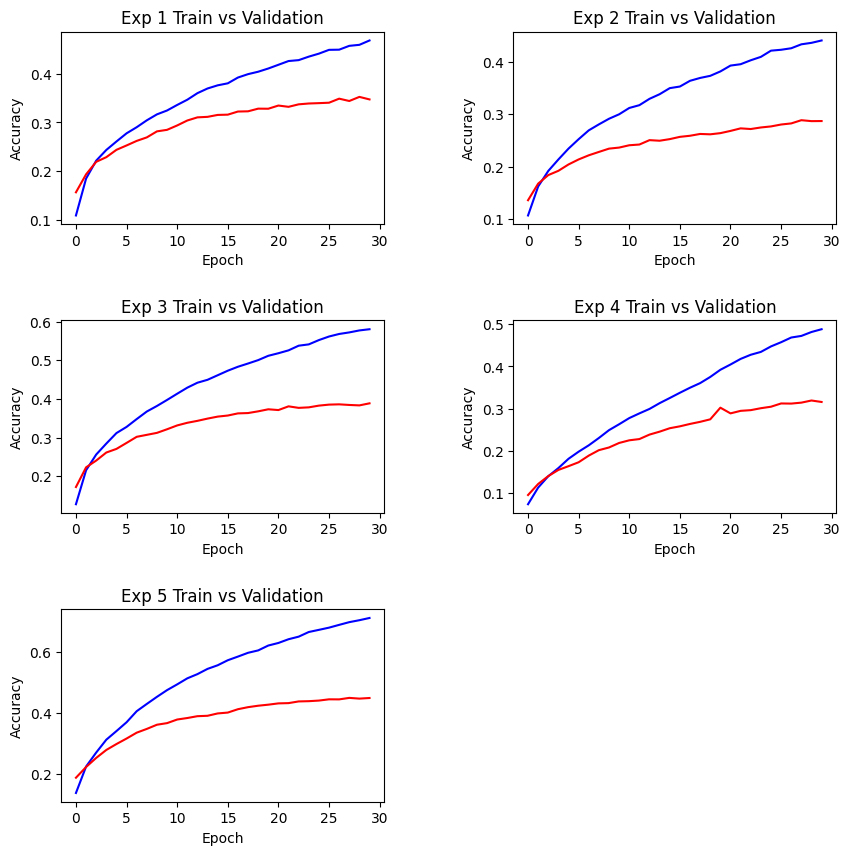

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.5)
n_rows = 3
n_cols = 2
for experiment_no, experiment in enumerate(experiments):
    ax = fig.add_subplot(n_rows, n_cols, experiment_no+1)
    ax.set_title(f"Exp {experiment_no+1} Train vs Validation")
    ax.plot(experiment.train_accuracy, c="b")
    ax.plot(experiment.validation_accuracy, c="r")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
plt.show()